<a href="https://colab.research.google.com/github/Bmogul/CS370/blob/main/take_at_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic.

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

(image_train, label_train), (image_test, label_test) = keras.datasets.cifar10.load_data()

def filterOutShip(x,y):
  filteredX = []
  filteredY = []
  for i in range(len(y)):
    if y[i][0] != 8:
      filteredX.append(x[i])
      filteredY.append(y[i])
  return filteredX, filteredY

image_train, label_train = filterOutShip(image_train, label_train)
image_test, label_test = filterOutShip(image_test, label_test)

image_train, image_test = np.array(image_train), np.array(image_test)
label_train, label_test = np.array(label_train), np.array(label_test)
image_train, image_test = image_train.astype('float32')/255, image_test.astype('float32')/255


170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, input_shape=(32,32,3))
label_train = label_train.flatten()

# Adding Additional Layers to calssify image
feature_map = resnet50.output
pooled_features = keras.layers.GlobalAveragePooling2D()(feature_map)
dense_layer = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.01))(pooled_features)
dropout_reg = keras.layers.Dropout(0.5)(dense_layer)
predictions = keras.layers.Dense(10, activation='softmax')(dropout_reg)

resnet50 = keras.models.Model(inputs=resnet50.input, outputs=predictions)

resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=.001), metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

epochs = 15
batch_size = 64

history = resnet50.fit(
    datagen.flow(image_train, label_train, batch_size=batch_size),
    steps_per_epoch=len(image_train) // batch_size,
    epochs=epochs,
    validation_data=(image_test, label_test)
)
resnet50.save('ps1a.h5')

313/313 [==============================] - 1s 2ms/step


<ipython-input-50-d945c8bba349>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


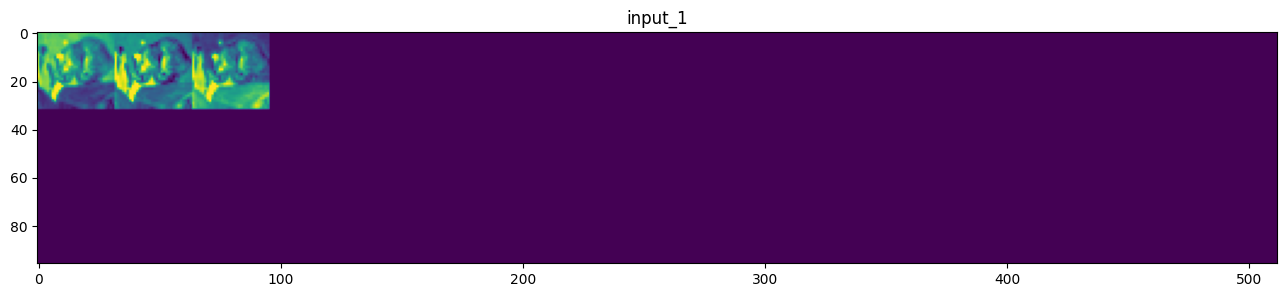

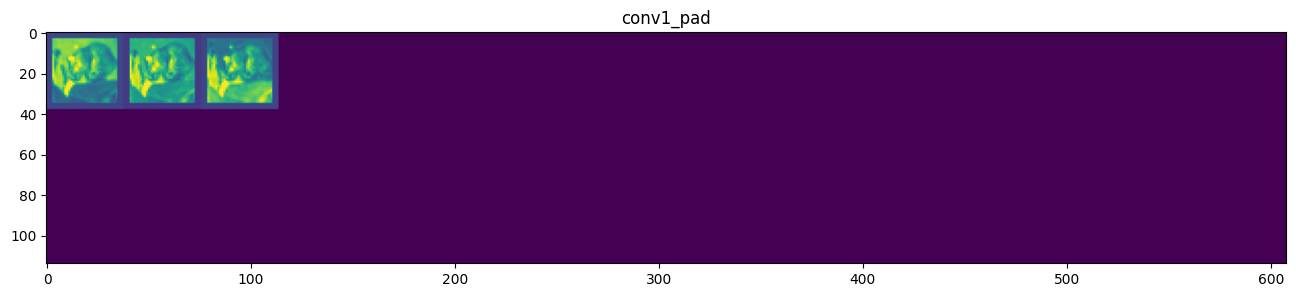

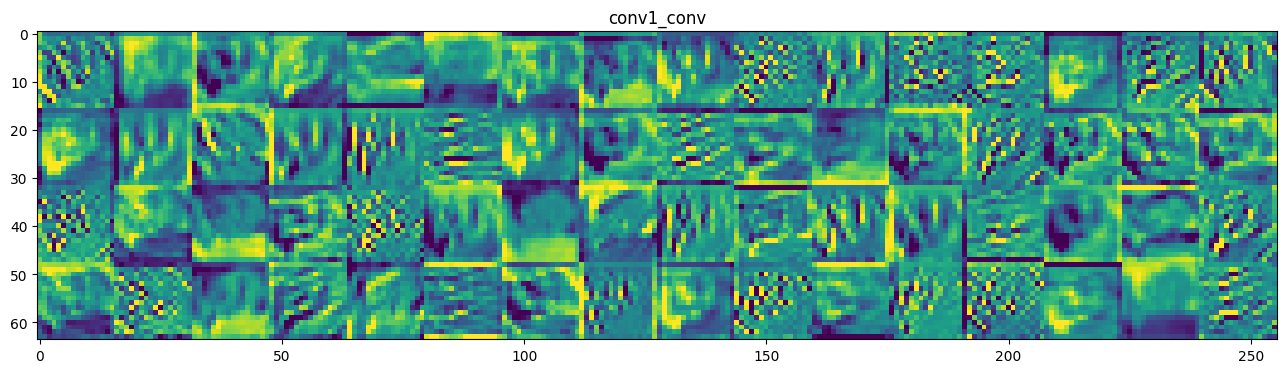

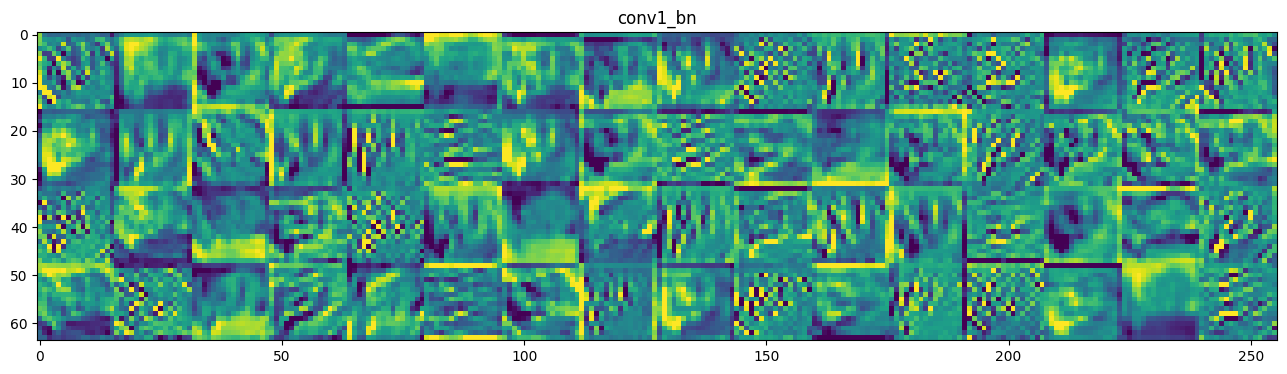

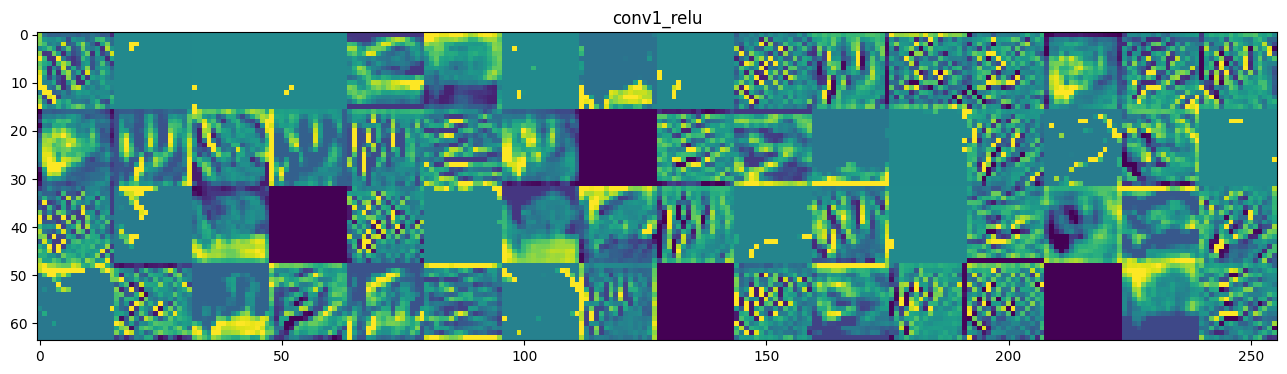

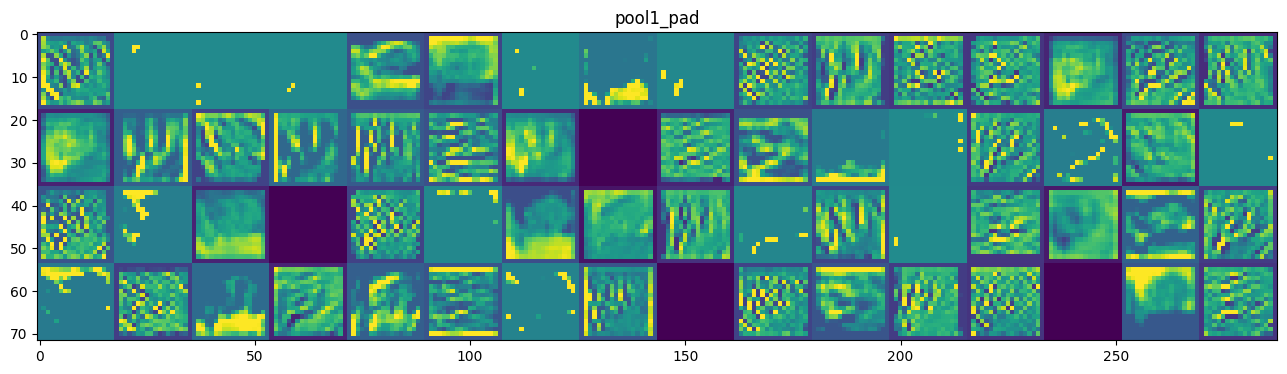

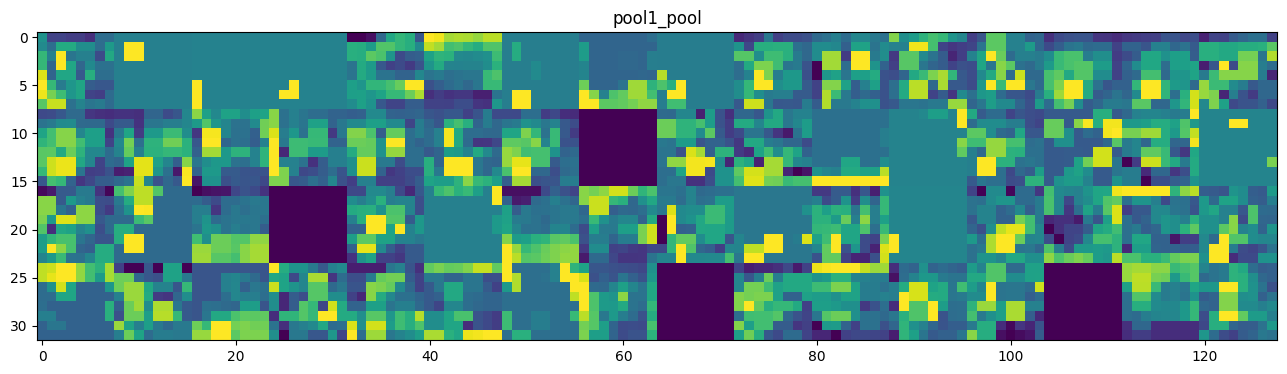

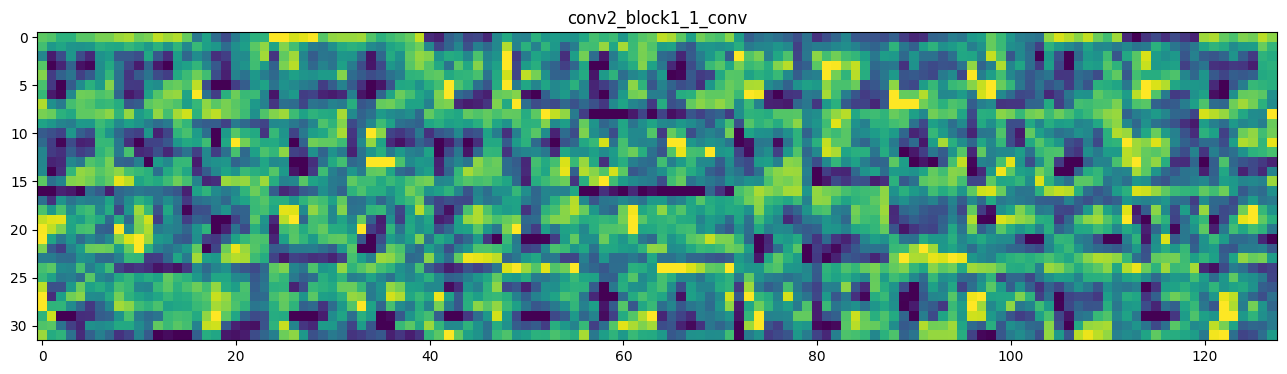

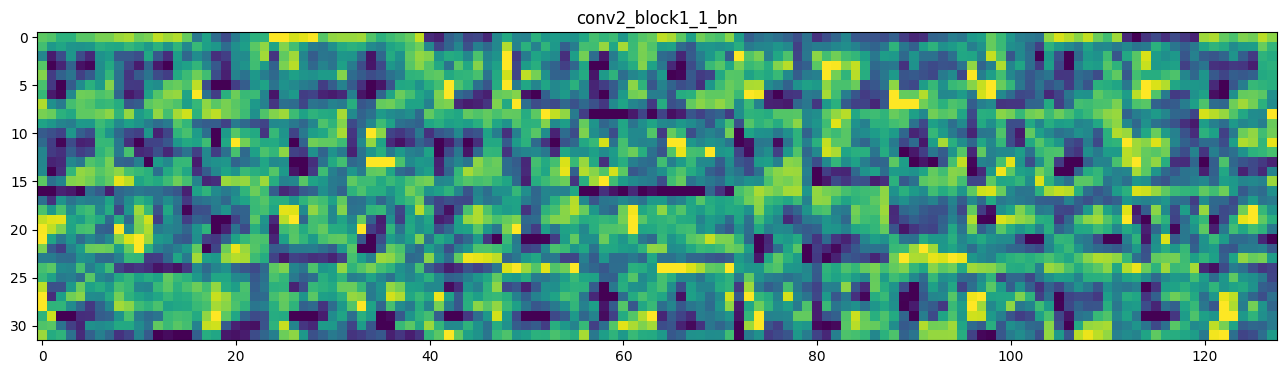

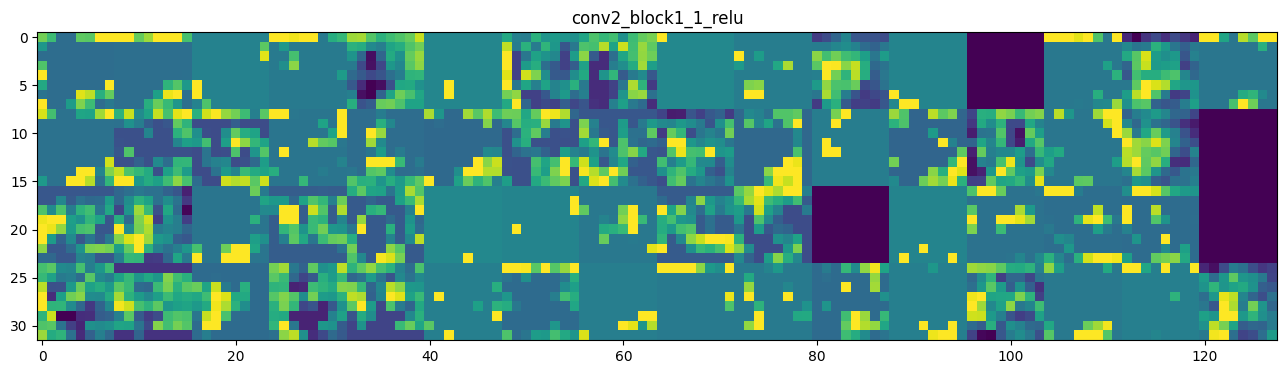

In [ ]:
resnet50 = keras.models.load_model('ps1a.h5')
def intermidiateViz(model):
    layer_outputs = [layer.output for layer in model.layers[:10]]
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(image_test)

    layer_names = []
    for layer in model.layers[:10]:
        layer_names.append(layer.name)

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        if n_cols == 0:
            n_cols = n_features
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_idx = col * images_per_row + row
                if channel_idx < n_features:  # Ensure index is within bounds
                    channel_image = layer_activation[0, :, :, channel_idx]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

intermidiateViz(resnet50)

plt.show()



In [ ]:
from tensorflow.keras import backend as K
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    # Create a custom model
    custom_model = tf.keras.Model(inputs=resnet50.input, outputs=resnet50.get_layer(layer_name).output)

    # Define input as a TensorFlow Variable
    input_img_data = tf.Variable(tf.random.normal((1, size, size, 3), mean=0.5, stddev=0.5))

    step = 1.
    for i in range(40):
        with tf.GradientTape() as tape:
            activation = custom_model(input_img_data)
            loss_value = tf.reduce_mean(activation[:, :, :, filter_index])

        grads = tape.gradient(loss_value, input_img_data)
        grads /= tf.sqrt(tf.reduce_mean(tf.square(grads)) + 1e-5)
        input_img_data.assign_add(grads * step)

    img = input_img_data[0].numpy()
    return deprocess_image(img)

plt.imshow(generate_pattern('conv2_block1_3_conv', 0))
plt.show()

1/1 [==============================] - 1s 1s/step
The predicted class is: FROG
[6]


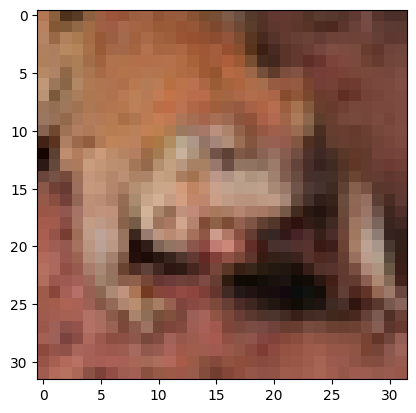

In [ ]:
predictions = resnet50.predict(np.expand_dims(image_test[5], axis=0))

class_names = ["AIRPLANE", "AUTOMOBILE", 'BIRD', 'CAT', 'DEER', 'DOG', 'FROG', 'HORSE', 'SHIP','TRUCK']

class_index = np.argmax(predictions)
class_label = class_names[class_index]

print(f"The predicted class is: {class_label}")
print(label_test[5])
plt.imshow(image_test[5])


## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model.

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`.

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [ ]:
# Insert your code here
model = keras.models.load_model('ps1a.h5')
(image_train, label_train), (image_test, label_test) = keras.datasets.cifar10.load_data()
# normalize data
image_train, image_test = np.array(image_train), np.array(image_test)
label_train, label_test = np.array(label_train), np.array(label_test)
image_train, image_test = image_train.astype('float32')/255, image_test.astype('float32')/255

binary_train, binary_test = np.zeros(label_train.shape), np.zeros(label_test.shape)
binary_train[label_train == 8], binary_test[label_test == 8] = 1, 1

#Feature Extraction:
for layer in model.layers:
  layer.trainable = False

feature_map = model.output
feature_map = keras.layers.Flatten()(feature_map)
dense_layer = keras.layers.Dense(256,activation='relu')(feature_map)

predictoins = keras.layers.Dense(1, activation='sigmoid')(dense_layer)
model_feature_extract = keras.models.Model(inputs=model.inputs, outputs=predictoins)

model_feature_extract.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_feature_extract.fit(image_train, binary_train, epochs=epochs, batch_size=batch_size, validation_data=(image_test, binary_test))
model_feature_extract.save('ps1bFE.h5')

#Fine Tuning
for layer in model.layers[-15:]:
  layer.trainable = True

feature_map = model.output
feature_map = keras.layers.Flatten()(feature_map)
dense_layer = keras.layers.Dense(256,activation='relu')(feature_map)

predictoins = keras.layers.Dense(1, activation='sigmoid')(dense_layer)
model_fine_tuning = keras.models.Model(inputs=model.inputs, outputs=predictoins)

model_fine_tuning.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_fine_tuning.fit(image_train, binary_train, epochs=epochs, batch_size=batch_size, validation_data=(image_test, binary_test))
model_fine_tuning.save('ps1bFT.h5')



Epoch 1/15
782/782 [==============================] - 12s 11ms/step - loss: 0.3087 - accuracy: 0.9006 - val_loss: 0.2805 - val_accuracy: 0.9023
Epoch 2/15
782/782 [==============================] - 7s 9ms/step - loss: 0.2786 - accuracy: 0.9049 - val_loss: 0.2737 - val_accuracy: 0.9047
Epoch 3/15
782/782 [==============================] - 8s 10ms/step - loss: 0.2735 - accuracy: 0.9063 - val_loss: 0.2671 - val_accuracy: 0.9074
Epoch 4/15
782/782 [==============================] - 7s 10ms/step - loss: 0.2701 - accuracy: 0.9076 - val_loss: 0.2656 - val_accuracy: 0.9071
Epoch 5/15
782/782 [==============================] - 8s 10ms/step - loss: 0.2683 - accuracy: 0.9078 - val_loss: 0.2616 - val_accuracy: 0.9117
Epoch 6/15
782/782 [==============================] - 7s 9ms/step - loss: 0.2665 - accuracy: 0.9090 - val_loss: 0.2593 - val_accuracy: 0.9113
Epoch 7/15
782/782 [==============================] - 7s 9ms/step - loss: 0.2651 - accuracy: 0.9088 - val_loss: 0.2579 - val_accuracy: 0.9119
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
782/782 [==============================] - 15s 13ms/step - loss: 0.2315 - accuracy: 0.9117 - val_loss: 0.2262 - val_accuracy: 0.9180
Epoch 2/15
782/782 [==============================] - 9s 12ms/step - loss: 0.2100 - accuracy: 0.9164 - val_loss: 0.2162 - val_accuracy: 0.9180
Epoch 3/15
782/782 [==============================] - 9s 11ms/step - loss: 0.2088 - accuracy: 0.9173 - val_loss: 0.2301 - val_accuracy: 0.9194
Epoch 4/15
782/782 [==============================] - 9s 12ms/step - loss: 0.2074 - accuracy: 0.9177 - val_loss: 0.2152 - val_accuracy: 0.9200
Epoch 5/15
782/782 [==============================] - 9s 11ms/step - loss: 0.2056 - accuracy: 0.9173 - val_loss: 0.2197 - val_accuracy: 0.9177
Epoch 6/15
782/782 [==============================] - 9s 12ms/step - loss: 0.2053 - accuracy: 0.9188 - val_loss: 0.2269 - val_accuracy: 0.9127
Epoch 7/15
782/782 [==============================] - 9s 11ms/step - loss: 0.2039 - accuracy: 0.9176 - val_loss: 0.2093 - val_accuracy: 0.919

313/313 [==============================] - 1s 2ms/step


<ipython-input-50-d945c8bba349>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


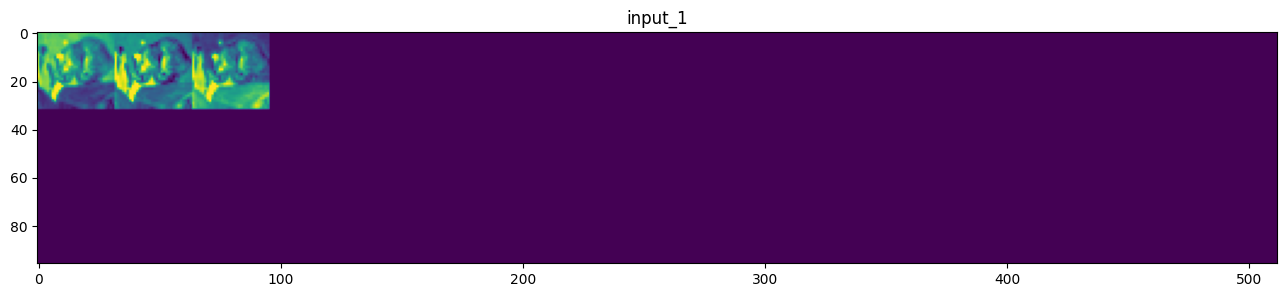

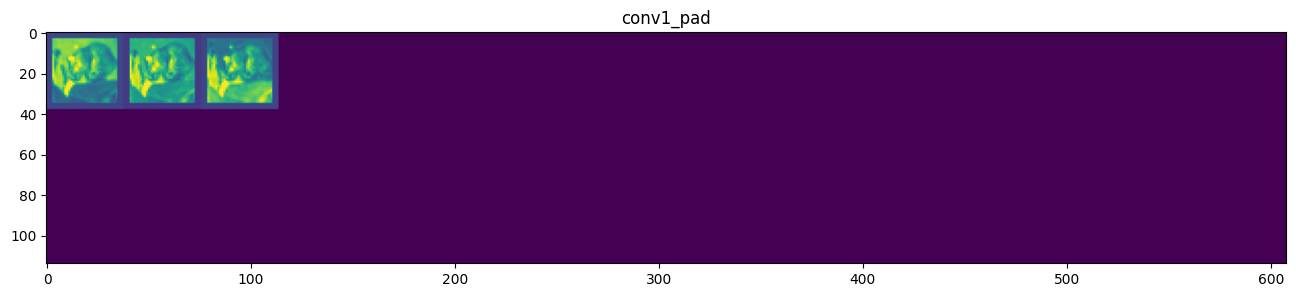

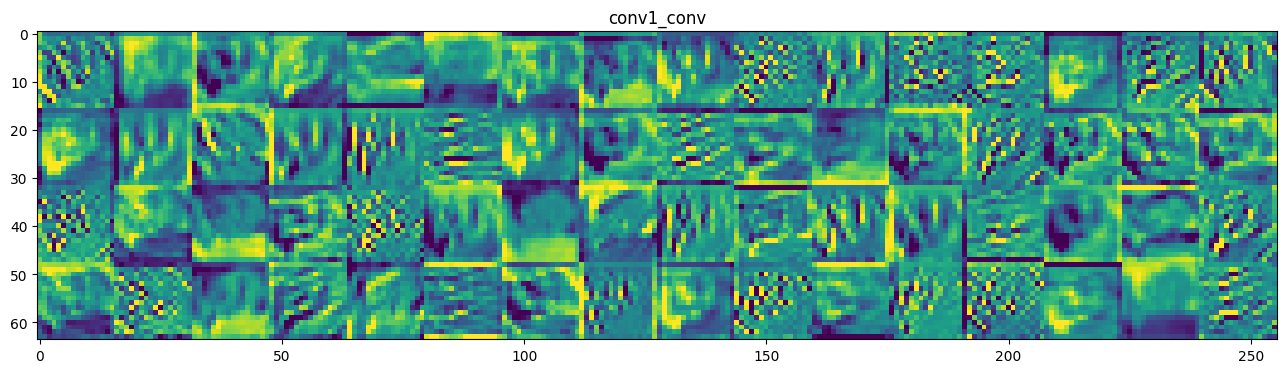

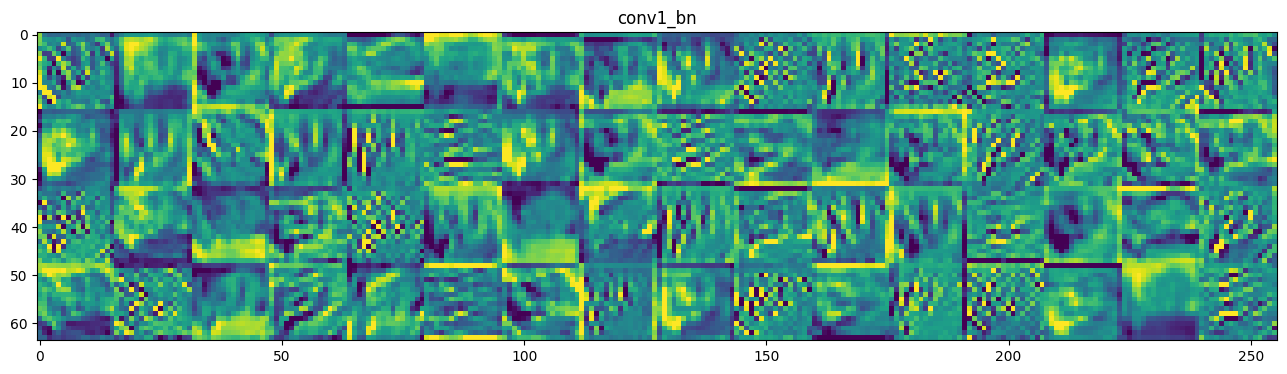

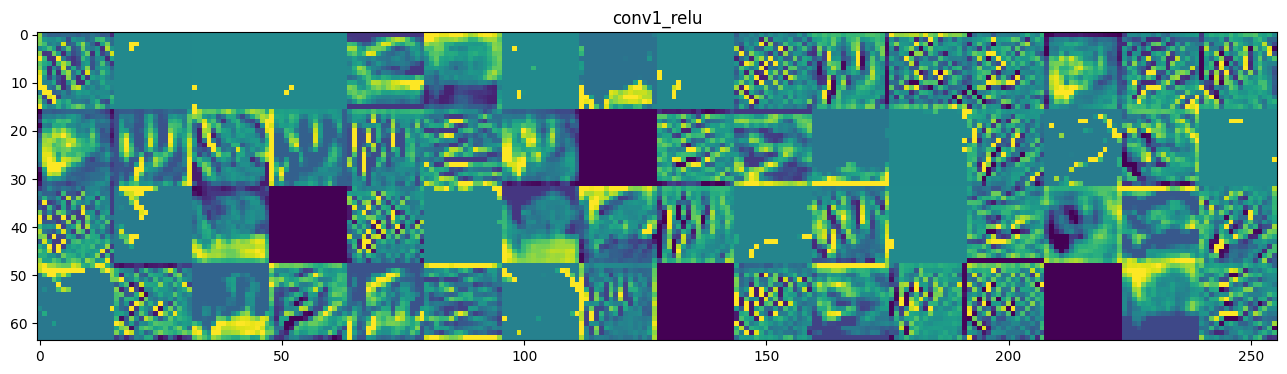

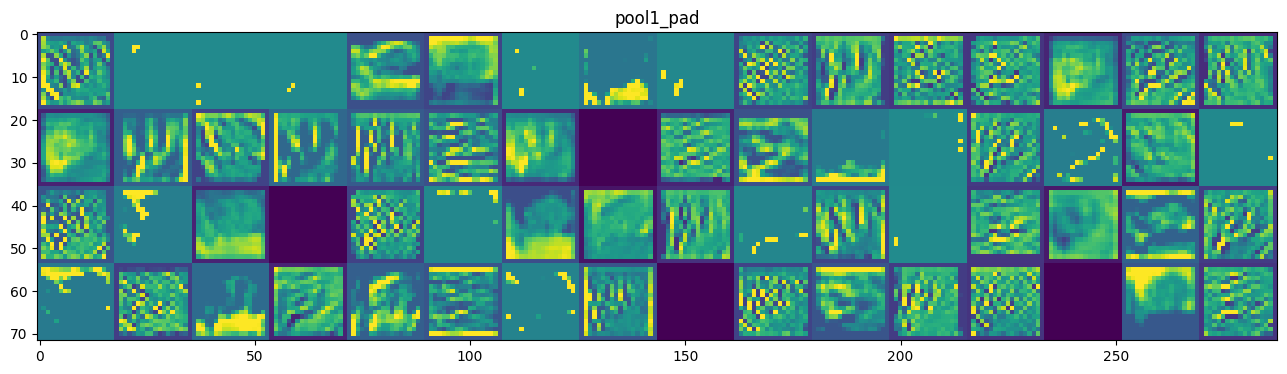

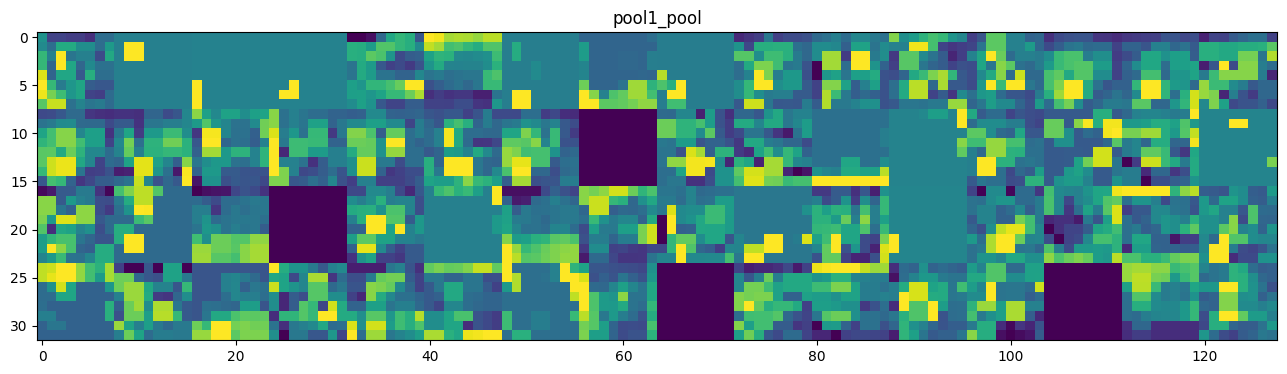

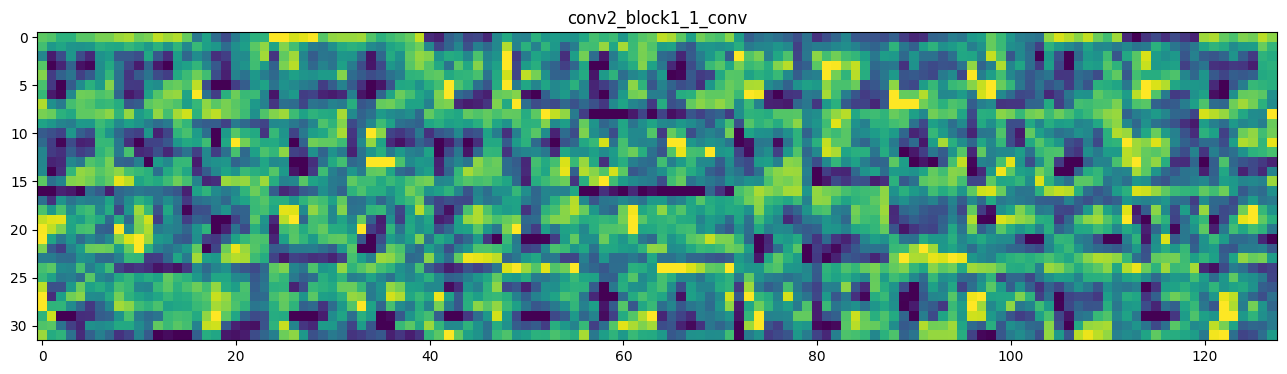

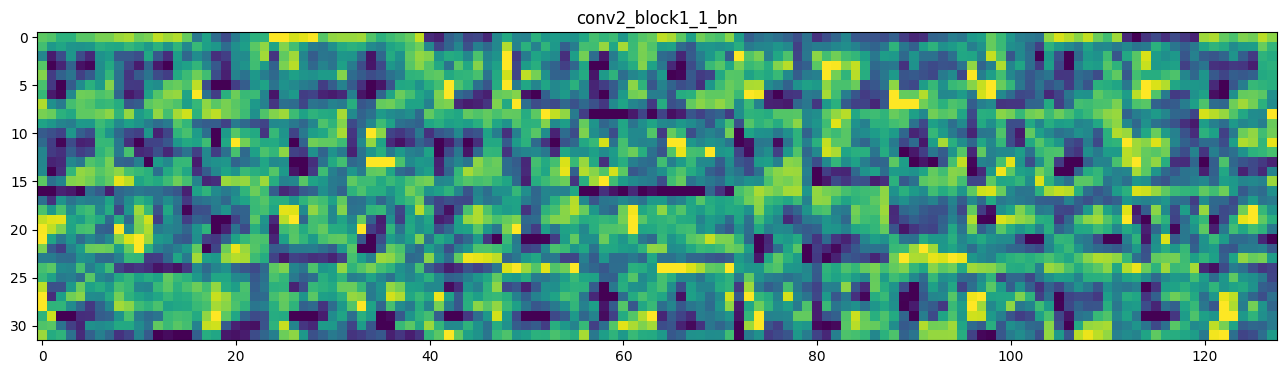

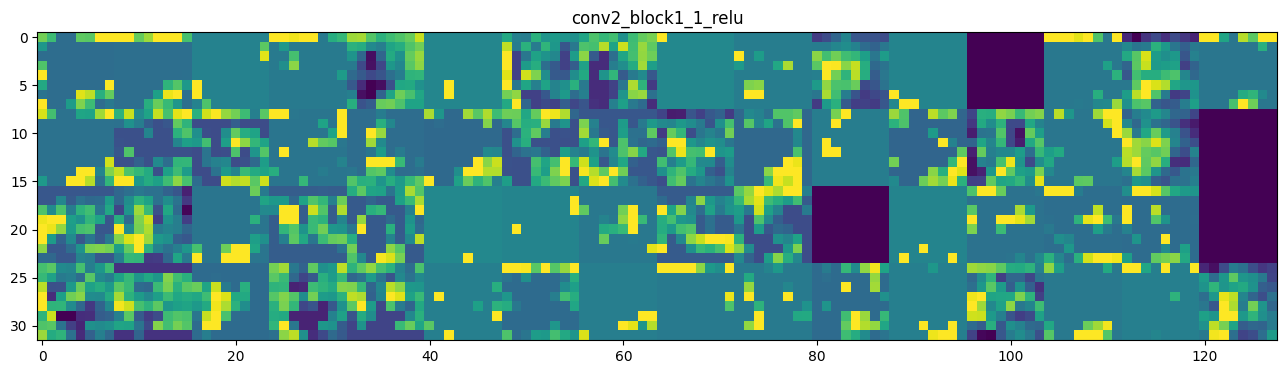

In [ ]:
intermidiateViz(model_feature_extract)

313/313 [==============================] - 1s 2ms/step


<ipython-input-50-d945c8bba349>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


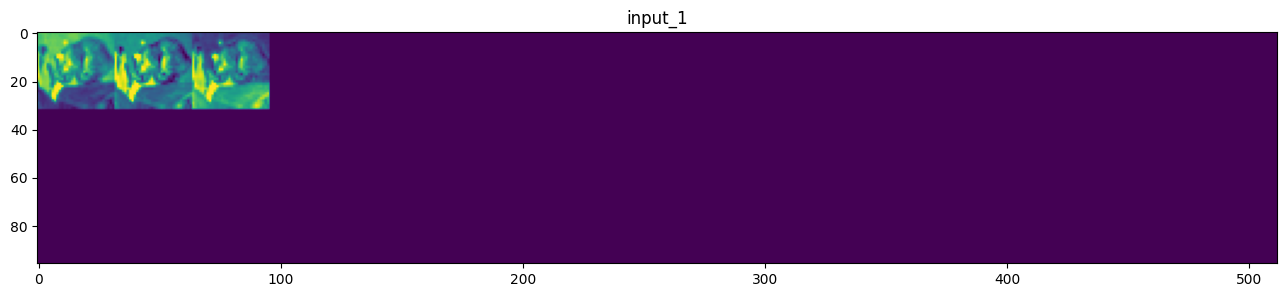

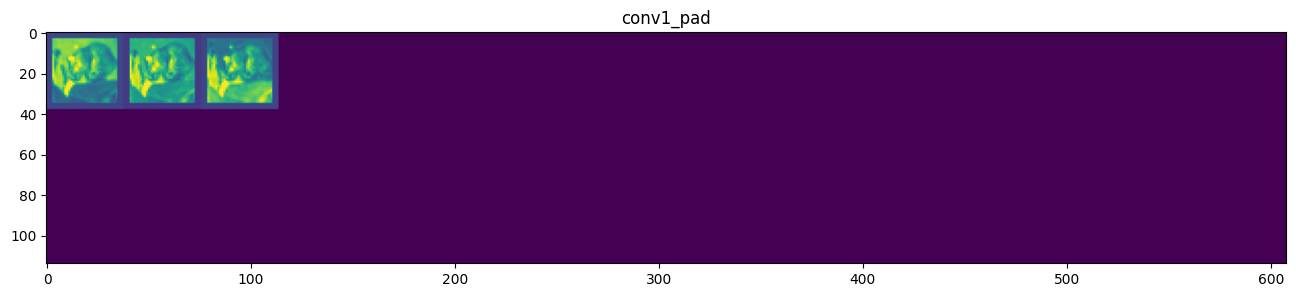

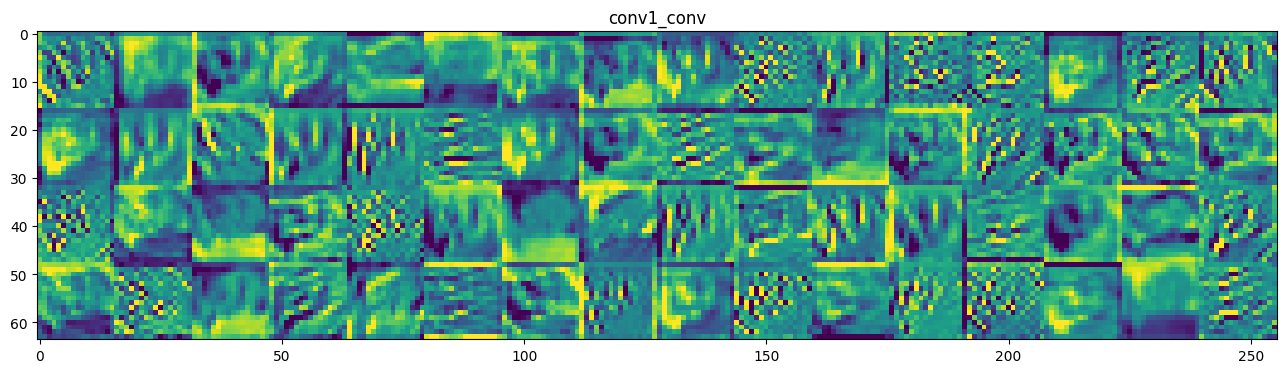

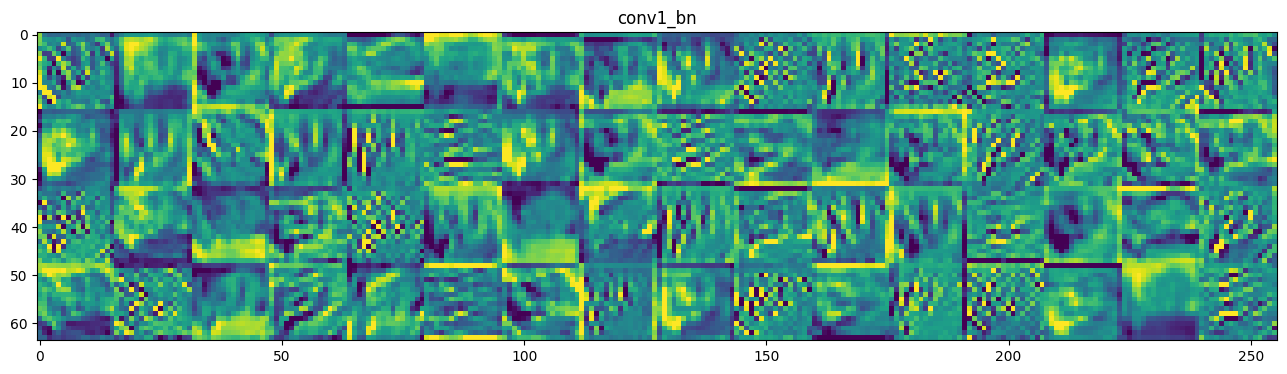

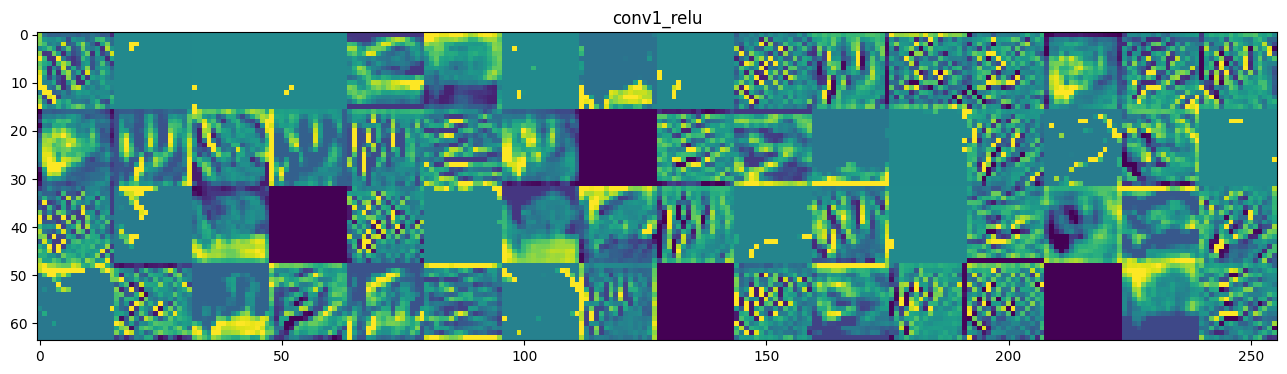

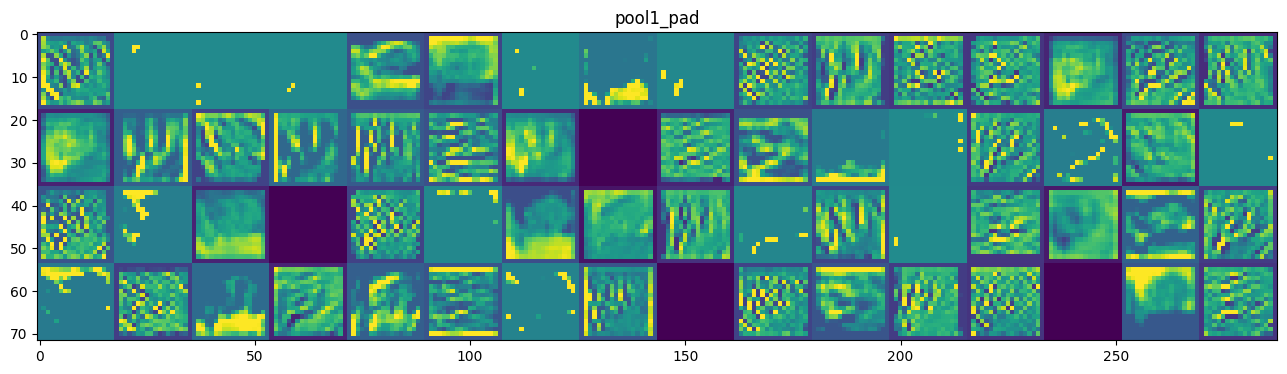

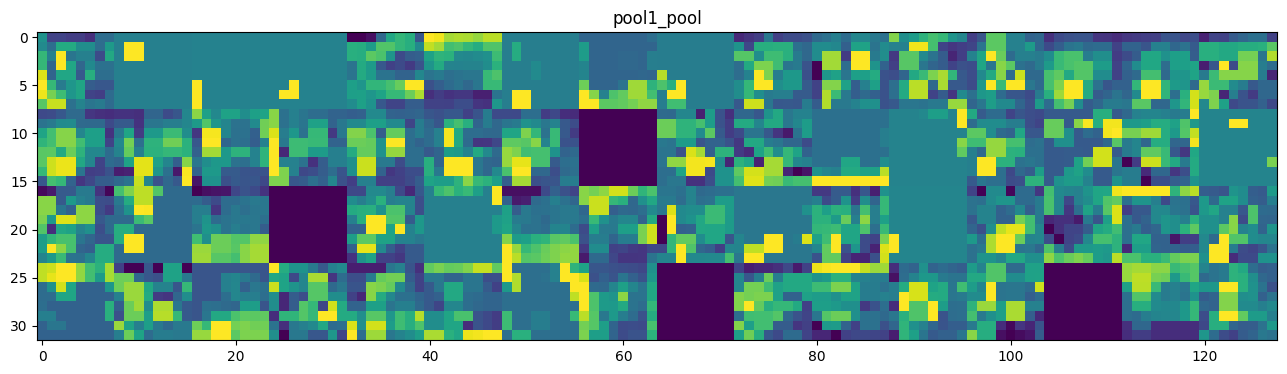

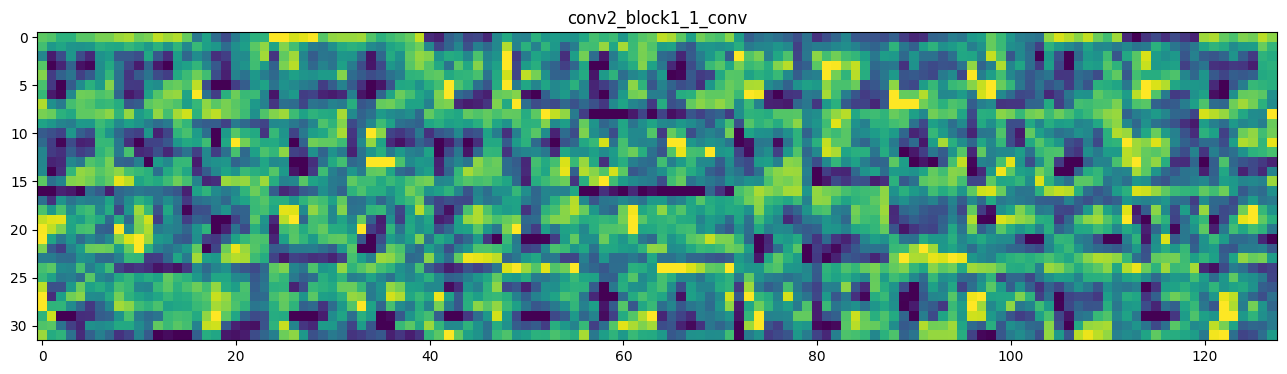

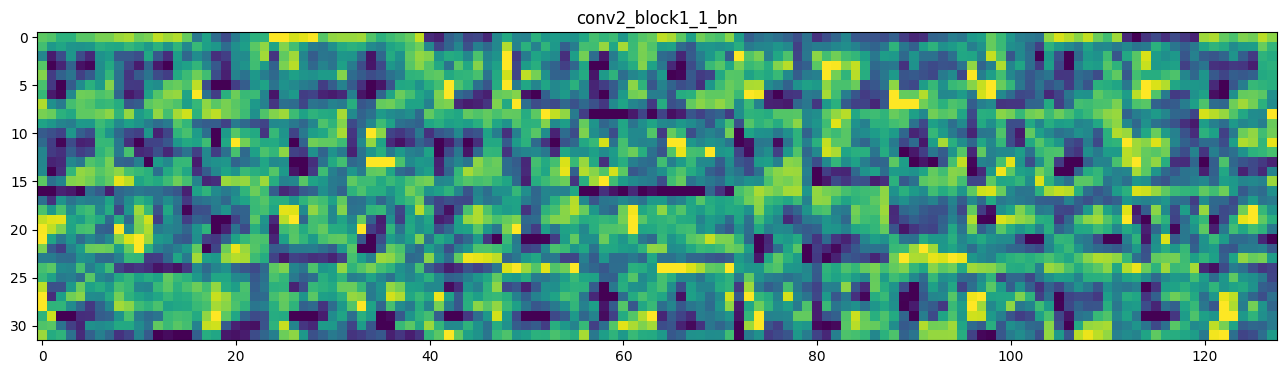

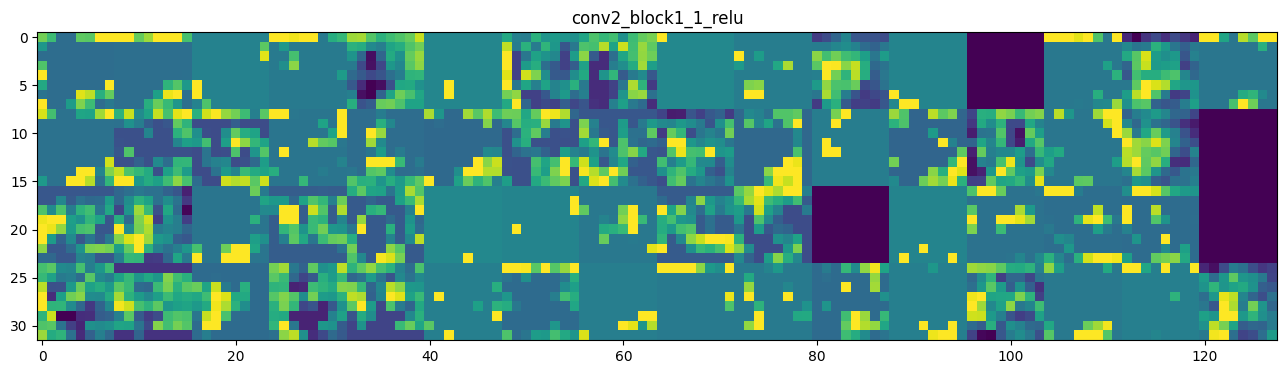

In [ ]:
intermidiateViz(model_fine_tuning)

In [ ]:
class_names = ["NOT SHIP", "SHIP"]

for i in range(10):
  predictions = model_feature_extract.predict(np.expand_dims(image_test[i], axis=0))
  class_index = np.argmax(predictions)
  class_label = class_names[class_index]
  if class_label == "SHIP":
    plt.text(0,0,f"{class_label}",color='black', fontsize=12, fontweight='bold')
    plt.text(0,10,f"{binary_test[i]}",color='black', fontsize=12, fontweight='bold')
    plt.imshow(image_test[i])
    plt.show()
